# Primary Notebook

## Local Code Imports - Do not delete

In [51]:
# DO NOT REMOVE THESE
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
# DO NOT REMOVE This
%reload_ext autoreload

In [3]:
## Uncomment to filter warnings
#import warnings
#warnings.filterwarnings('ignore')

In [53]:
## DO NOT REMOVE
## import local src module -
## src in this project will contain all your local code
## clean_data.py, model.py, visualize.py, custom.py
#from src import make_data as mk
from src import visualize as viz
from src import model as mdl
from src import custom as cm
#from src import pandas_operators as po

#def test_src():
    #mk.test_make_data()
    #viz.test_viz()
    #mdl.test_model()
    #po.test_pandas()

#    return 1

In [5]:
#test_src()

## Code Imports

In [6]:
## Some standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from joblib import dump
%matplotlib inline

# Project Overview

# EDA, Data Cleaning & Feature Engineering

In [7]:
user_factors = pd.read_csv('../data/processed/user_factors.csv')

In [8]:
user_factors_scaled = pd.read_csv('../data/processed/user_factors_scaled.csv')

In [33]:
user_factors_scaled.drop(['Unnamed: 0'], axis=1, inplace=True)

# AWS KMeans Evaluation

In [42]:
error = [8113978.666767631, 7354872.282449911, 6779693.947846839, 6494419.943265818, 6161394.18380805, 5969178.495847053, 5775171.418613084, 5586181.465087898, 5459016.548945165, 5320932.3011912545, 5191293.46220535, 5090035.762150701, 4986521.909023397, 4919589.194313965, 4845781.722909153, 4738299.132215889, 4697877.381008717, 4626969.254411039, 4562072.290577676, 4519194.064635965, 4451951.002486911, 4413293.651221422, 4361910.62076177, 4339251.383448499, 4277987.088258287, 4244595.896973764, 4199613.235502976, 4156505.1574725825, 4131992.707043184, 4095312.234922758, 4069049.097594653, 4033434.5349058285, 4011851.7686528624, 3976083.217075855, 3949592.2147446494, 3938039.9457209697, 3899577.4734264542, 3881519.333619226, 3850186.2378393123, 3823198.4054184584, 3808773.2587171667, 3784495.988544207, 3761565.3901316617, 3746975.2839278127, 3723729.6121418993, 3699745.0362992603, 3680091.71095213, 3667951.1618961715, 3653602.1354131224, 3632124.2721405267, 3608965.8957424895, 3593001.8085261723, 3577712.029614562, 3560315.3167280406, 3552552.115932628, 3532308.4953923486, 3511941.7114949734, 3498429.793736455]

In [43]:
len(error)

58

In [56]:
cluster = list(range(2, 60))

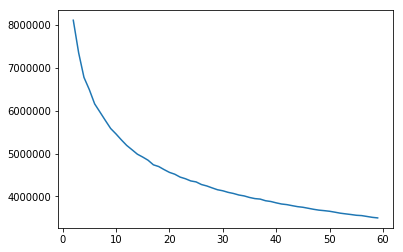

In [51]:
plt.plot(cluster, error);

In [58]:
error_diff = []
for i in list(range(0,56)):
    diff = error[i]-error[i+1]
    error_diff.append(diff)

In [59]:
cluster_diff = list(range(2, len(error_diff)+2))

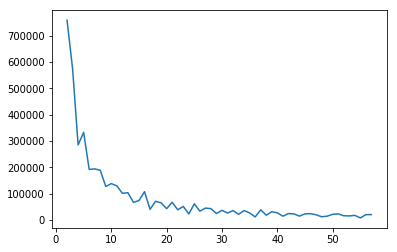

In [60]:
plt.plot(cluster_diff, error_diff);

# KMeans Model

In [35]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 9)

In [36]:
kmeans.fit(user_factors_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=9, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [37]:
preds = kmeans.predict(user_factors_scaled)

In [55]:
centroids = kmeans.cluster_centers_ 

In [71]:
centroids_df = pd.DataFrame(centroids)

In [72]:
centroids_df.to_csv('../data/processed/centroids.csv')

# Gradient Boosting Machine

In [38]:
preds_df = pd.DataFrame(preds, columns=['cluster'])
user_factors_with_preds = user_factors.copy()
user_factors_with_preds['cluster'] = preds_df
X = user_factors_with_preds.drop(['id', 'cluster'], axis=1)
y = preds
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=142, shuffle=True)

,id,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,cluster
0,1,-0.380470,0.103641,0.310486,0.078450,0.129363,-0.033363,0.030401,-0.360824,-0.213137,...,-0.480875,0.194733,0.479119,0.328390,-0.123725,-0.188246,-0.525000,-0.133443,-0.167593,1
1,2,-0.226508,0.167774,0.536940,0.235142,-0.036765,0.118235,0.024486,-0.449235,-0.145772,...,-0.314272,0.170148,0.567598,0.492936,-0.072118,-0.063404,-0.715515,0.038176,-0.056638,8
2,3,-0.240955,0.179579,0.439598,0.231143,0.003269,0.110166,0.018843,-0.457156,-0.184155,...,-0.375902,0.142993,0.607431,0.525451,-0.006926,-0.018648,-0.715832,0.011471,-0.136575,6
3,4,-0.271722,0.041331,0.368844,-0.016227,0.102699,0.047941,0.020815,-0.335555,-0.272367,...,-0.530468,0.179969,0.527210,0.440110,0.124539,-0.082171,-0.663929,-0.065500,-0.327186,1
4,5,-0.368851,0.104798,0.349379,0.013516,0.070510,0.036399,-0.017281,-0.401808,-0.266340,...,-0.581576,0.247609,0.590982,0.318466,0.053089,-0.191376,-0.671003,-0.065487,-0.266448,1


In [45]:
gbc = GradientBoostingClassifier()
param_grid = {'learning_rate':[.15], 
             'max_depth': [10],
             'min_samples_split': [25],
             'n_estimators': [42],
             'max_features': [7]}
gs_gbc = GridSearchCV(gbc, param_grid, cv=5)
gs_gbc.fit(X_train, y_train)
gbc_train_preds = gs_gbc.predict(X_train)
gbc_test_preds = gs_gbc.predict(X_test)
accuracy_score(y_test, gbc_test_preds), accuracy_score(y_train, gbc_train_preds)

(0.9599441845194123, 1.0)

In [46]:
print(confusion_matrix(y_test, gbc_test_preds))
print(confusion_matrix(y_train, gbc_train_preds))

[[ 4781     0     0    27    86     0    63    41    51]
 [    0 11728    25    17     0    64    62    64    68]
 [    0    53  3335    20    60     2    51     0    63]
 [   27    48    12  3206     9    16    29    45    26]
 [   46     0    40    19  4570     0    39     1    76]
 [    0    98     1    27     0  6246     2    66     1]
 [   46    63    26    18    31     0  7506    41   115]
 [   29    89     0    24     0    42    59  8484    42]
 [   25    80    32    25    53     0   113    42  8619]]
[[15167     0     0     0     0     0     0     0     0]
 [    0 35737     0     0     0     0     0     0     0]
 [    0     0 10810     0     0     0     0     0     0]
 [    0     0     0 10983     0     0     0     0     0]
 [    0     0     0     0 14318     0     0     0     0]
 [    0     0     0     0     0 19062     0     0     0]
 [    0     0     0     0     0     0 23393     0     0]
 [    0     0     0     0     0     0     0 26886     0]
 [    0     0     0     0     

In [48]:
dump(gs_gbc, '../models/fifp_classification.joblib') 

['../models/fifp_classification.joblib']

# Clusters Distances and Ratings

In [64]:
cluster_distances = cm.cluster_distances(centroids)
cluster_distances.to_csv('../data/processed/cluster_distances_df.csv')

In [77]:
item_factors_unstacked = pd.read_csv('../data/processed/item_factors.csv', index_col=['id'] )

In [122]:
len(item_factors_unstacked)

28755

In [ ]:
item_factors_unstacked_transposed = item_factors_unstacked.T

In [84]:
centroid_ratings_T_df = cm.centroid_ratings(centroids,item_factors_unstacked)
centroid_ratings_T_df.head()

,0,1,2,3,4,5,6,7,8
id,,,,,,,,,
1,-0.574680,0.844685,-1.006109,-7.964015,1.771695,-3.114418,-0.538622,0.763970,3.833670
2,1.034825,-0.337082,0.714705,-5.945640,4.620170,-5.204503,-0.132226,-0.566126,3.937726
3,1.438076,-0.592763,1.162251,-5.542225,5.178301,-5.648232,0.102577,-0.743866,3.696378
4,2.321293,-0.936388,-0.820854,-4.300232,4.091545,-4.349577,-0.733859,0.335650,3.257888
5,2.761233,-1.173833,0.131194,-5.098391,5.388513,-5.980635,0.123744,-0.302588,3.626031


In [87]:
movies_df = pd.read_csv('../data/raw/movies.csv')
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [200]:
cm.get_recommendations(0, centroids, item_factors_unstacked)

['Gettysburg (1993)', 'Santa Claus Is a Stinker (Le Père Noël est une ordure) (1982)', 'Rainmaker, The (1997)', 'Snowriders (1996)', 'Visions of Light: The Art of Cinematography (1992)', 'Before Midnight (2013)', 'Bull Durham (1988)', 'Heartbeats (Les amours imaginaires) (2010)', 'Unknown (2006)', 'Murder at 1600 (1997)']


In [201]:
cm.get_recommendations(2, centroids, item_factors_unstacked)

['Midnight Express (1978)', 'Frost/Nixon (2008)', 'Left Behind II: Tribulation Force (2002)', 'Mother Night (1996)', 'Yours, Mine and Ours (1968)', 'Love and Pigeons (1985)', 'Shooter (2007)', 'Survivor (2015)', 'Friends of Eddie Coyle, The (1973)', 'Baxter (1989)']


In [ ]:
tkinter